In [1]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('data/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<Axes: >

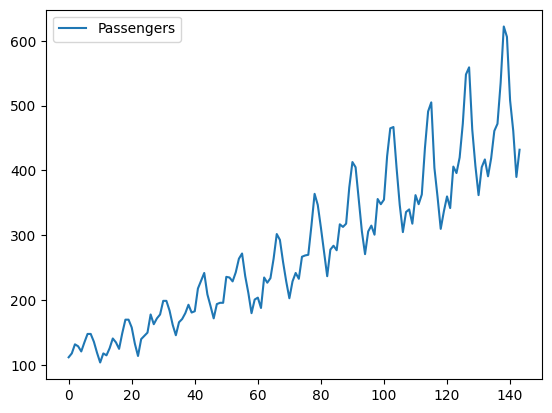

In [2]:
df.plot()

In [3]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1):

        #часть за данные ааа
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0
        
        
    def start_timer(self):
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self):
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self):
        return self.timer.sum()

    def get_times(self):
        return self.timer
    
    def step_package(self):
        self.start_timer()
        self.w = self.w - self.h * self.grad()

    
    def step_mini_batch(self):
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self):
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()

            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2)

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1)

In [4]:
df['Month'] = df['Month'].apply(lambda x: time.mktime(time.struct_time([list(map(int, x.split("-")))[0]+31] + [list(map(int, x.split("-")))[1]] + [0]*7)))



In [5]:
scaler = MinMaxScaler()
df['Month'] = scaler.fit_transform(df[['Month']].to_numpy())
print(df)

        Month  Passengers
0    0.000000         112
1    0.007123         118
2    0.013787         132
3    0.020910         129
4    0.027803         121
..        ...         ...
139  0.971967         606
140  0.979090         508
141  0.985983         461
142  0.993107         390
143  1.000000         432

[144 rows x 2 columns]


In [6]:


x = df[['Month']].to_numpy()
y = df[['Passengers']].to_numpy()
print(df['Month'])

0      0.000000
1      0.007123
2      0.013787
3      0.020910
4      0.027803
         ...   
139    0.971967
140    0.979090
141    0.985983
142    0.993107
143    1.000000
Name: Month, Length: 144, dtype: float64


In [7]:
print("Наш стохастический градиентный спуск")
PSD = GradientDescent(x, y, h=10**(-3), eps=0.0001, min_iterations=10000, logging=True) 

Наш стохастический градиентный спуск


In [8]:
PSD.fit()

Величина ошибки на каждом шаге
Шаг 1: ошибка 91528.6035;
Шаг 2: ошибка 91102.8522;
Шаг 3: ошибка 90679.2501;
Шаг 4: ошибка 90257.7863;
Шаг 5: ошибка 89838.4499;
Шаг 6: ошибка 89421.2302;
Шаг 7: ошибка 89006.1164;
Шаг 8: ошибка 88593.0979;
Шаг 9: ошибка 88182.1641;
Шаг 10: ошибка 87773.3043;
Шаг 11: ошибка 87366.5082;
Шаг 12: ошибка 86961.7653;
Шаг 13: ошибка 86559.0651;
Шаг 14: ошибка 86158.3973;
Шаг 15: ошибка 85759.7516;
Шаг 16: ошибка 85363.1179;
Шаг 17: ошибка 84968.4858;
Шаг 18: ошибка 84575.8453;
Шаг 19: ошибка 84185.1862;
Шаг 20: ошибка 83796.4986;
Шаг 21: ошибка 83409.7725;
Шаг 22: ошибка 83024.9979;
Шаг 23: ошибка 82642.1649;
Шаг 24: ошибка 82261.2637;
Шаг 25: ошибка 81882.2846;
Шаг 26: ошибка 81505.2177;
Шаг 27: ошибка 81130.0535;
Шаг 28: ошибка 80756.7822;
Шаг 29: ошибка 80385.3943;
Шаг 30: ошибка 80015.8803;
Шаг 31: ошибка 79648.2307;
Шаг 32: ошибка 79282.4359;
Шаг 33: ошибка 78918.4867;
Шаг 34: ошибка 78556.3737;
Шаг 35: ошибка 78196.0876;
Шаг 36: ошибка 77837.6191;
Шаг 37

array([ 91.46487129, 377.82401102])

In [9]:
PSD.w

array([ 91.46487129, 377.82401102])

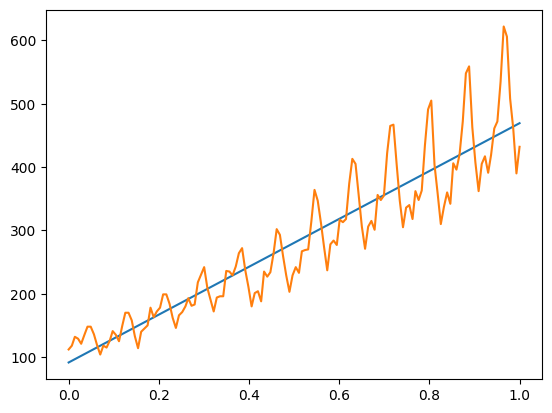

In [10]:
plt.plot(x, PSD.w[0] + PSD.w[1]*x)
plt.plot(df['Month'], df['Passengers'])

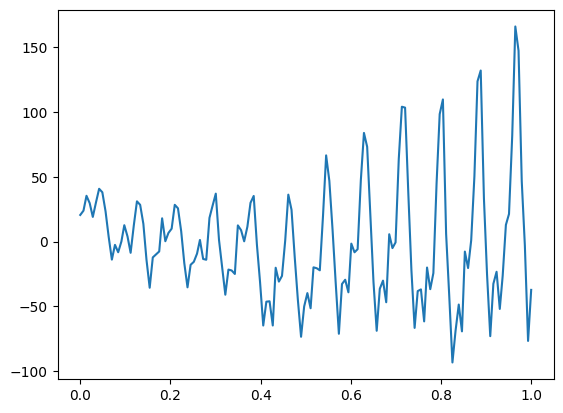

In [11]:
plt.plot(df['Month'], df['Passengers'] - (PSD.w[0] + PSD.w[1]*x)[ :, 0])

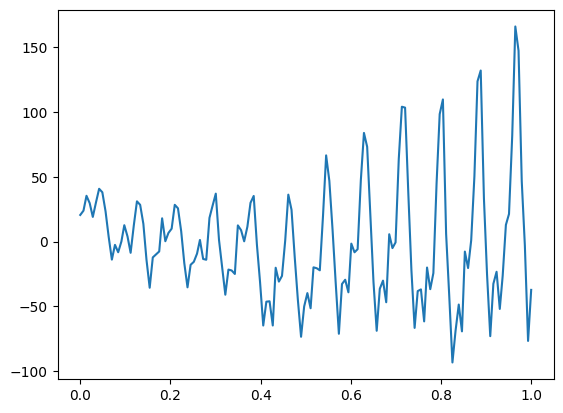

In [21]:
w = df['Month']
ht = df['Passengers'].to_numpy() - (PSD.w[0] + PSD.w[1]*x)[ :, 0]
plt.plot(w, ht)

In [74]:

class TimeRow(GradientDescent):
    
    def __init__(self, t, y, *args, **kwargs):
        super().__init__(self, t, y, *args, **kwargs)
        scaler = MinMaxScaler()
        t = scaler.fit_transform(t)
        self.fit()
        self.ut = PSD.w[0] + PSD.w[1]*t
        self.fur = TimeRow.Fourier(3)
        
        
        
    class Fourier:
        def __init__(self, m):
            self.a = []
            self.b = []
            self.length = None
            self.t = None
            self.m = m
    
        def build(self, t, ht):
            self.length = len(w) // 2 // self.m
            self.a = [0] * self.length
            self.b = [0] * self.length
            self.w = 2 * np.pi
            for i in range(self.length):
                for j in range(len(ht)):
                    self.a[i] += ht[j] * np.cos(t[j] * self.w * i)
                    self.b[i] += ht[j] * np.sin(t[j] * self.w * i)
            self.a = np.array(self.a) / self.length
            self.b = np.array(self.b) / self.length
    
        def calc(self, x):
            new_x = [0] * len(x)
            for i in range(len(x)):
                for j in range(self.length):
                    new_x[i] += np.cos(x[i] * self.w * j) * self.a[j]
                    new_x[i] += np.sin(x[i] * self.w * j) * self.b[j]
            return new_x


In [77]:

fourier.build(w, ht)


In [78]:
ht_ = fourier.calc(w)
print(ht_)

[np.float64(-124.25187836232556), np.float64(-49.41950303067749), np.float64(62.1784921106112), np.float64(149.06664614616182), np.float64(160.60955628592367), np.float64(113.30576604616519), np.float64(59.73380280212496), np.float64(37.23828956720162), np.float64(47.55346115324872), np.float64(56.97517480320391), np.float64(36.98033914594053), np.float64(-7.929466340766769), np.float64(-48.18972349551912), np.float64(-49.96609066123396), np.float64(-15.669908499903208), np.float64(36.106337504537315), np.float64(67.69240130904417), np.float64(66.22164182031086), np.float64(43.31669430077045), np.float64(20.024814274699658), np.float64(7.90300607704474), np.float64(-0.8333152156932329), np.float64(-19.4012523176108), np.float64(-45.464336334535524), np.float64(-62.30101361753188), np.float64(-48.79152404054428), np.float64(-9.386178737280352), np.float64(43.31589510772057), np.float64(75.1001164324077), np.float64(72.38670356814569), np.float64(44.154500315135024), np.float64(11.844677

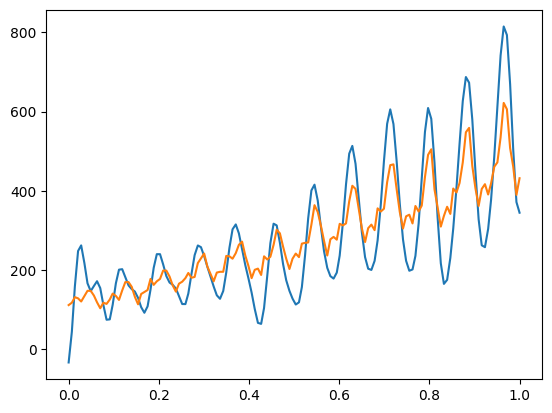

In [79]:
plt.plot(w, ht_ + (PSD.w[0] + PSD.w[1]*x)[ :, 0])
plt.plot(df['Month'], df['Passengers'])